# STACKED BiLSTM WITH SPACY EMBEDDINGS / SENTIMENT / UPSAMPLING

In [2]:
!pip install matplotlib
!pip install -U pip setuptools wheel
!pip install -U spacy
!pip install spacytextblob
!python -m spacy download en_core_web_lg
!pip install -U nltk
!pip install gensim
!pip install python-Levenshtein
!pip install ftfy
!pip install emoji
!pip install pycld2
!pip install xlrd
!pip install openpyxl

  Using cached matplotlib-3.4.3-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached kiwisolver-1.3.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.1 MB)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
  Using cached pip-21.2.4-py3-none-any.whl (1.6 MB)
  Using cached setuptools-58.1.0-py3-none-any.whl (816 kB)
  Using cached wheel-0.37.0-py2.py3-none-any.whl (35 kB)
  Attempting uninstall: wheel
    Found existing installation: wheel 0.36.2
    Uninstalling wheel-0.36.2:
      Successfully uninstalled wheel-0.36.2
  Attempting uninstall: setuptools
    Found existing installation: setuptools 56.0.0
    Uninstalling setuptools-56.0.0:
      Successfully uninstalled setuptools-56.0.0
  Attempting uninstall: pip
    Found existing installation: pip 21.1.1
    Uninstalling pip-21.1.1:
      Successfully uninstalled pip-21.1.1
  Using cached spacy-3.1.3-cp37-cp3

In [3]:
import numpy as np
import pandas as pd
import string
import itertools
import time
import os
import re
import sklearn
import spacy
import pickle
import random
import gc

from sentiment import get_sentiment
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors
from sklearn.metrics import classification_report, confusion_matrix
from text_preprocess import clean_text, unfold_contractions, remove_emoji

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, Adadelta, Adagrad, Adamax, Ftrl
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import ( Activation, Dropout, Dense, Flatten, LSTM, Bidirectional, SpatialDropout1D,
                                      RepeatVector, MaxPooling1D, GlobalMaxPooling1D, GlobalMaxPool1D, Embedding,
                                      Input, Concatenate, Reshape, Flatten, Conv1D, GlobalAveragePooling1D )

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [4]:
def plot_confusion_matrix(cm, classes,                      
                          title='CONFUSION MATRIX',
                          cmap=plt.cm.PuBu):         # originally plt.cm.Blues; also good: BuPu,RdPu,PuRd,OrRd,Oranges
    '''
    Plot the confusion matrix    
    '''
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
            
    plt.figure(figsize=(4,4))
    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.tight_layout()
    plt.show()

In [5]:
# DIFFERENT TEXT CLEANING METHODS
def remove_digits(s):
    s = s.translate( str.maketrans(string.digits, ' '*len(string.digits)) )
    s = re.sub('\s+', ' ', s)
    return s.strip()

def remove_punct(s):
    '''
    To avoid words being glued together, replace punct with spaces because
    there are complex words with '-' separator,
    and some people forget there should be a space after punctuation
    '''
    s = s.translate( str.maketrans(string.punctuation, ' '*len(string.punctuation) ) )
    s = re.sub('\s+', ' ', s)
    return s.strip()

def remove_non_alpha(s):
    '''
    To avoid words being glued together, replace punct with spaces because
    there are complex words with '-' separator,
    and some people forget there should be a space after punctuation
    '''
    s = s.translate( str.maketrans( punctuation, ' '*len(punctuation) ) )
    s = s.translate( str.maketrans( string.digits, ' '*len(string.digits) ) )
    s = re.sub('\s+', ' ', s)
    return s.strip()

def remove_stopwords(s):
    s = s.strip().split()
    s = [ w.strip() for w in s if remove_non_alpha(w).lower() not in sw ]
    return ' '.join(s)

def mask_entities(s):
    '''
        Replace simplified named entities with their type,
        if a word is named entity; otherwise, lemmatize word
    '''    
    ent_types = { 
                    'number':       ['CARDINAL', 'ORDINAL'],
                    'place':        ['LOC'],
                    'name':         ['PERSON'],
                    'percent':      ['PERCENT'],
                    'money':        ['MONEY'],
                    'organization': ['ORG'],
                }
        
    # replace entities w/generic names, lemmatize
    out = []
    s = nlp(s)
    for t in s:
        ent_type = ''
        for key in ent_types:
            if t.ent_type_ in ent_types[key]:
                ent_type = key
                break
        if ent_type:
            out.append( ent_type )
        else:
            out.append( t.lemma_ )
        
    # remove entity masks repeated several times in a row
    stack = ['',]
    for item in out:
        if item == stack[-1]:
            continue
        stack.append( item )        
        
    return ' '.join( stack[1:] )


def convert_emoticons(s):
    return s.replace(':)', 'happy_face').replace(':D', 'happy_face')

punctuation = ''.join([c for c in string.punctuation if c not in "'!?"])
sw = [ 'a', 'an', 'the' ]

In [6]:
def dedupe( df1, df2, col_ ):
    '''
        df2 should not contain annything from df1 in column col_
        (e.g. df2 = smaller test set OR smaller set for 1 category)
        to preserve smaller df2, duplicates are deleted from df1
    '''
    original_length = df1.shape[0]
    df2_sents = df2[col_].values
    df1 = df1[ ~df1[col_].isin(df2_sents) ]
    print( f'\tDropping {original_length - df1.shape[0]} duplicates')
    return df1, df2


def upsample( df_, to_oversample_ ):
    '''
        Upsample df_ by to_oversample_ more samples excluding re-evaluation data
    '''    
    # EXCLUDE RE-EVALUATED DATA FROM OVERSMPLING IF IT'S PRESENT    
    if 'source' in df_.columns:
        df_to_oversample = df_[ df_['source'] != 'reeval_2021' ]
        print( '\tData shape for this category without re-eval:', df_to_oversample.shape )
    else:
        df_to_oversample = df_
        
    # OVERSAMPLE AND CONCAT W/ORIGINAL DF_
    replace = False
    if len(df_to_oversample) < to_oversample_:
        replace = True        

    df_upsampled = df_to_oversample.sample( n=to_oversample_, replace=replace )
    df_          = pd.concat([ df_, df_upsampled ])
        
    return df_.sample( frac=1 )


def intersect_length( df1, df2, col_ ):
    '''
        Return counts of the same records in df1 and df2 in column col_    
    '''    
    len1 = len([ i for i in df1[col_].values if i in df2[col_].values ])
    len2 = len([ i for i in df2[col_].values if i in df1[col_].values ])
    return len1, len2

## 1. Prepare data

### Read, augment, and deduplicate data

In [ ]:
file = ''
df   = pd.read_csv( file , sep='\t', encoding='utf-8' )

print( 'Data size:', df.shape )
print( 'Unique sentences:', len( df['sentence'].unique() ), '\n' )
print( 'Missing values:\n\n', df.isna().sum(), sep='' )
df.head(2)

In [ ]:
# wrong labels
convert_2unk = [ ]
len(convert_2unk)
df.loc[ df['sentence'].isin(convert_2unk), 'label'] = 'unk'
df[ df['sentence'].isin(convert_2unk)][['sentence', 'label']]

In [9]:
nlp = spacy.load("en_core_web_lg")
#nlp.remove_pipe('parser')
ml_categories = [ ]
len( ml_categories )

15

In [10]:
#df = df[ df['is_subtle'] == 0 ]
df = df[ df['label'].isin( ml_categories ) ]
df = df.drop(['award_reason', 'is_group_award', 'group_award_id', 'keywords'], axis=1)

df['target'] = df['label'].apply( lambda x: 0 if x == 'unk' else 1 )

In [11]:
df['target'].value_counts()

1    5911
0    4932
Name: target, dtype: int64

In [12]:
# ONLY FOR BINARY CLASSIFICATION - DEDUPE BETWEEN CATEGORIES, FAVOR CATEGORY 1 (my class)
print(df.shape)
df1 = df[ df['target'] == 1 ].copy()
df0 = df[ df['target'] == 0 ].copy()
df0, df1 = dedupe( df0, df1, 'sentence' )
df = pd.concat([ df0, df1 ]).copy().sample(frac=1).reset_index(drop=True)
print(df.shape)

(10843, 11)
	Dropping 6 duplicates
(10837, 11)


In [13]:
# ONLY FOR BINARY CLASSIFICATION - DEDUPE TRAIN / VAL / TEST SETS. FAVOR TEST, THEN VAL SET
print(df.shape)
df_train = df[ df['subset'] == 'train' ].copy()
df_val   = df[ df['subset'] == 'val' ].copy()
df_test  = df[ df['subset'] == 'test' ].copy()

df_train, df_test = dedupe( df_train, df_test, 'sentence' )
df_val, df_test   = dedupe( df_val, df_test, 'sentence' )
df_train, df_val  = dedupe( df_train, df_val, 'sentence' )
df = pd.concat([ df_train, df_val, df_test ]).copy().sample(frac=1).reset_index(drop=True)
print(df.shape)

(10837, 11)
	Dropping 90 duplicates
	Dropping 33 duplicates
	Dropping 69 duplicates
(10645, 11)


In [14]:
# MIN NUM WORDS FOR SENT AND MESSAGE
df['length1'] = df['sentence'].apply( lambda x: len(x.split()) )
df['length2'] = df['award_text'].apply( lambda x: len(x.split()) )
print(df['length1'].min(), df['length1'].max())
print(df['length2'].min(), df['length2'].max())

1 99
2 370


### Preprocess text

In [15]:
# MERGE SENTENCE AND AWARD TEXT, IF NEEDED
#df['sentence2'] = df['sentence'] + ' ' + df['award_text']
#df.head()

In [16]:
print( 'Cleaning text ...', end=' ')
df['sentence_lower'] = df['sentence'].apply( convert_emoticons )
df['sentence_lower'] = df['sentence_lower'].apply( lambda x: remove_emoji(x, to_text=True) )
df['sentence_lower'] = df['sentence_lower'].apply( unfold_contractions )
df['sentence_lower'] = df['sentence_lower'].apply( mask_entities )
df['sentence_lower'] = df['sentence_lower'].apply( lambda x: x.lower() )
df['sentence_lower'] = df['sentence_lower'].apply( remove_non_alpha )
df['sentence_lower'] = df['sentence_lower'].apply( remove_stopwords )
print('Done!')

# UNIQUE WORDS (very approx. because punctuation may be included)
num_words_cased   = len(set(' '.join(df['sentence'].tolist()).split()))
num_words_uncased = len(set(' '.join(df['sentence_lower'].tolist()).split()))
print( 'Unique cased words (uncleaned):' , num_words_cased )
print( 'Unique uncased words:          ' , num_words_uncased )

df['length'] = df['sentence_lower'].apply( lambda x: len(x.split()) )
maxlen       = df['length'].max()
print( 'Maximum sentence length:', maxlen, '\n' )

Cleaning text ... Done!
Unique cased words (uncleaned): 20193
Unique uncased words:           7065
Maximum sentence length: 91 



### Augment data

In [ ]:
# LOAD SENTENCES FROM ANNOTATION GUIDELINES
print( 'Augmenting data....')
df_aug = pd.read_excel( '',
                        sheet_name='guidelines',
                        engine='openpyxl',
                      )
df_aug = df_aug.dropna()

df_aug['sentence_lower'] = df_aug['sentence'].apply( clean_text )
df_aug['sentence_lower'] = df_aug['sentence_lower'].apply( convert_emoticons )
df_aug['sentence_lower'] = df_aug['sentence_lower'].apply( lambda x: remove_emoji(x, to_text=True) )
df_aug['sentence_lower'] = df_aug['sentence_lower'].apply( unfold_contractions )
df_aug['sentence_lower'] = df_aug['sentence_lower'].apply( mask_entities )
df_aug['sentence_lower'] = df_aug['sentence_lower'].apply( lambda x: x.lower() )
df_aug['sentence_lower'] = df_aug['sentence_lower'].apply( remove_non_alpha )
df_aug['sentence_lower'] = df_aug['sentence_lower'].apply( remove_stopwords )

# VERIFY LENGTH IS NOT 0
df_aug['length'] = df_aug['sentence_lower'].apply( lambda x: len(x.split()))
print( 'Lengths of sentences:', sorted( list(set(df_aug['length'].values))) )

# ADD COLUMNS TO MERGE WITH MAIN DF
df_aug['target'] = 1
df_aug['subset'] = 'train'
df_aug = df_aug[['sentence_lower', 'target', 'label', 'subset', 'source']]
for col in df.columns:
    if col not in df_aug.columns:
        df_aug[col] = np.nan
print( 'Shape of augmented data:', df_aug.shape )
df_aug.head()

In [19]:
already_in_test_set = [ i for i in df_aug['sentence_lower'].tolist() if i in df[ df['subset'] == 'test' ]['sentence_lower'].tolist() ]
df_aug = df_aug[ ~df_aug['sentence_lower'].isin( already_in_test_set )]
df_aug.shape

(605, 15)

In [ ]:
# LOAD KEYWORDS FROM CURRENT PATTERNS MODEL
kw = pd.read_excel( 'data/kw.xlsx', engine='openpyxl' )

kw['sentence_lower'] = kw['keyword'].apply( clean_text )
kw['sentence_lower'] = kw['sentence_lower'].apply( convert_emoticons )
kw['sentence_lower'] = kw['sentence_lower'].apply( lambda x: remove_emoji(x, to_text=True) )
kw['sentence_lower'] = kw['sentence_lower'].apply( unfold_contractions )
kw['sentence_lower'] = kw['sentence_lower'].apply( mask_entities )
kw['sentence_lower'] = kw['sentence_lower'].apply( lambda x: x.lower() )
kw['sentence_lower'] = kw['sentence_lower'].apply( remove_non_alpha )
kw['sentence_lower'] = kw['sentence_lower'].apply( remove_stopwords )

# VERIFY LENGTH IS NOT 0
kw['length'] = kw['sentence_lower'].apply( lambda x: len(x.split()))
print( 'Lengths of sentences:', sorted( list(set(kw['length'].values))) )

# ADD COLUMNS TO MERGE WITH MAIN DF
kw['target'] = 1
kw['source'] = 'guide'
kw['subset'] = 'train'
kw = kw[['sentence_lower', 'target', 'label', 'subset', 'source']]
for col in df.columns:
    if col not in kw.columns:
        kw[col] = np.nan
#kw = kw[ df.columns ]
print( 'Shape of keywords data:', kw.shape )
kw.head()

In [21]:
# MERGE KEYWORDS WITH MAIN DF
print( df.shape )
df = pd.concat([ df, kw, df_aug ])
df = df.sample( frac=1 )
print( df.shape )

(10645, 15)
(11583, 15)


### Get sentiment

In [22]:
# FUNCTIONS TO CONVERT TEXT TO SENTIMENTS
def convert_sentiment( l ):
    '''
        Convert list of sentiment scores into 20 bins to build embeddings later    
    '''
    return [ round(i*10) + 10 for i in l ]


def infer_sentiment(s, pos=False):
    '''
    Get sentiment scores as a dict only for select POS, and 0 score for rest    
    '''
    #pos_included = ['ADJ', 'NOUN', 'PROPN', 'INTJ']
    pos_included = ['ADJ', 'NOUN', 'PROPN', 'VERB', 'ADV', 'INTJ']
    s = nlp(s)
    sentiments = get_sentiment(s)    
    if pos:
        for t in s:
            if t.text.lower() in sentiments and t.pos_ not in pos_included:
                sentiments[ t.text ] = None
            if t.lemma_.lower() in sentiments and t.pos_ not in pos_included:
                sentiments[ t.lemma_ ] = None                
    sentiments = {k: v for k,v in sentiments.items() if v}
    
    res = []
    for t in s:
        res.append( sentiments.get( t.text.lower(), 0.0 ) )
                
    return convert_sentiment( res )

In [23]:
df['sentiment_feats'] = df['sentence_lower'].apply( lambda x: infer_sentiment(x, pos=True) )

In [24]:
# VERIFY BINS
list(set([ i for sublist in df[ 'sentiment_feats' ].tolist() for i in sublist ]))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [25]:
# VERIFY A SENTENCE
i = 26
df[['sentence_lower', 'sentiment_feats']].values.tolist()[i]

['you work long hour each week to lead team in design process all while manage significant customer and internal expectation',
 [10, 9, 9, 11, 10, 10, 10, 12, 14, 10, 16, 10, 10, 10, 11, 12, 11, 10, 9, 15]]

### Upsample categories for more even representation
AVOID UPSAMPLING FROM DATA WITH SOURCE `reeval_2021` (IT'S NOT ARBITRATED)

In [26]:
# SEPARATE DF_TRAIN, DF_TEST, AND UNK
df_train     = df[ df['subset'].isin(['train', 'val']) ]
df_test      = df[ df['subset']=='test' ].copy()
df_train_unk = df_train[ df_train['label']=='unk' ].copy()
print( df_train.shape, df_test.shape, df_train_unk.shape )

(10665, 16) (918, 16) (4414, 16)


In [29]:
# SEPARATE CATS NOT TO UPSAMPLE
cats_not_to_upsample = ['imposing_work', 'undesired_work', 'superiority']
not_upsampled_dfs = []
for cat in cats_not_to_upsample:
    not_upsampled_dfs.append( df_train[ df_train['label']==cat ].copy() )
print([ df_.shape for df_ in not_upsampled_dfs] )

[(1734, 16), (999, 16), (890, 16)]


In [ ]:
# UPSAMPLE CATS TO UPSAMPLE
cats_to_upsample = [ ]
max_size = 900
upsampled_dfs = []
for cat in cats_to_upsample:
    df_temp = df_train[ df_train['label']==cat ].copy()
    to_upsample = max_size - df_temp.shape[0]
    print( f'Upsampling category {cat} from shape {df_temp.shape} to 1000 data points' )
    upsampled_dfs.append( upsample( df_temp, to_upsample ) )
print([ df_.shape for df_ in upsampled_dfs] )

In [31]:
# MERGE myclass CATS, UPSAMPLE UNK, MERGE EVERYTHING TOGETHER
df_train_myclass = pd.concat( not_upsampled_dfs + upsampled_dfs )
df_train_myclass = df_train_myclass.sample( frac=1 )
print( 'Upsampled myclass categories:', df_train_myclass.shape )

to_upsample = df_train_myclass.shape[0] - df_train_unk.shape[0]
if to_upsample > 0:
    print( f'Upsampling unk by {to_upsample} rows')
    df_train_unk = upsample( df_train_unk.copy(), to_upsample )
print('Final size of unk:', df_train_unk.shape)

df_train = pd.concat([ df_train_myclass.copy(), df_train_unk.copy() ])
for i in range(10):
    df_train = df_train.sample(frac=1).reset_index(drop=True)
print( 'Final size of df_train:', df_train.shape )

Upsampled bias categories: (13523, 16)
Upsampling unk by 9109 rows
	Data shape for this category without re-eval: (3858, 16)
Final size of unk: (13523, 16)
Final size of df_train: (27046, 16)


In [34]:
# REMOVE TEMP DFs
del not_upsampled_dfs
del upsampled_dfs
del df_train_unk
del df_train_myclass
del df

### Train-test split and tokenization

In [35]:
X_train = df_train['sentence_lower'].values
y_train = df_train['target'].values
X_test  = df_test['sentence_lower'].values
y_test  = df_test['target'].values

X_train_sentim = df_train['sentiment_feats'].values
X_test_sentim  = df_test['sentiment_feats'].values

X_train, X_train_sentim, y_train = sklearn.utils.shuffle( X_train, X_train_sentim, y_train )
X_test, X_test_sentim, y_test    = sklearn.utils.shuffle( X_test, X_test_sentim, y_test    )

print( 'Shape of train / test data:', X_train.shape, X_test.shape, X_train_sentim.shape, X_test_sentim.shape,
       y_train.shape, y_test.shape )

Shape of train / test data: (27046,) (918,) (27046,) (918,) (27046,) (918,)


In [37]:
#del df_train, df_val, df_test, df
print('maxlen =', maxlen)
df_train['target'].value_counts()

maxlen = 91


1    13523
0    13523
Name: target, dtype: int64

In [38]:
# KERAS TOKENIZER
tokenizer = Tokenizer(
                       #num_words=11000,           # sentence + award_text
                       num_words=7000,             # sentence
                       lower=True,
                       oov_token='oov',
                       filters='"#$%&()*+,-./:;<=>@[\\]^_`{|}~\t\n',        # removed '!' and '?'
                     )
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size:', vocab_size)

# CHECK IF NUM TOKENS AND NUM SENTIMENT SCORES IS THE SAME
count = 0
for i,j in zip(X_train, X_train_sentim):
    if len(i) != len(j):
        count += 1        
print(f'Total num elements in X_train: {len(X_train)}; elements with lengths not matching: {count}')

count = 0
for i,j in zip(X_test, X_test_sentim):
    if len(i) != len(j):
        count += 1        
print(f'Total num elements in X_test: {len(X_test)}; elements with lengths not matching: {count}')

X_train        = pad_sequences(X_train, padding='post', truncating='post', maxlen=maxlen)
X_test         = pad_sequences(X_test, padding='post', truncating='post', maxlen=maxlen)
X_train_sentim = pad_sequences(X_train_sentim, padding='post', truncating='post', maxlen=maxlen)
X_test_sentim  = pad_sequences(X_test_sentim, padding='post', truncating='post', maxlen=maxlen)

Vocabulary size: 6871
Total num elements in X_train: 27046; elements with lengths not matching: 82
Total num elements in X_test: 918; elements with lengths not matching: 3


In [39]:
time_stamp = time.strftime("%Y%m%dT%H%M")

In [40]:
print('Current tokenizer time stamp:', time_stamp)
wdir          = 'data/'
use_sentiment = True

tokenizer_filepath = wdir + f'{time_stamp}_tokenizer.pkl'
X_train_filepath   = wdir + f'{time_stamp}_X_train.pkl'
y_train_filepath   = wdir + f'{time_stamp}_y_train.pkl'
X_test_filepath    = wdir + f'{time_stamp}_X_test.pkl'
y_test_filepath    = wdir + f'{time_stamp}_y_test.pkl'

with open(tokenizer_filepath, 'wb') as f:
    pickle.dump( tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL )
    
with open(X_train_filepath, 'wb') as f:
    pickle.dump( X_train, f, protocol=pickle.HIGHEST_PROTOCOL )
    
with open(y_train_filepath, 'wb') as f:
    pickle.dump( y_train, f, protocol=pickle.HIGHEST_PROTOCOL )
    
with open(X_test_filepath, 'wb') as f:
    pickle.dump( X_test, f, protocol=pickle.HIGHEST_PROTOCOL )
        
with open(y_test_filepath, 'wb') as f:
    pickle.dump( y_test, f, protocol=pickle.HIGHEST_PROTOCOL )


if use_sentiment:
    X_train_sentim_filepath = wdir + f'{time_stamp}_X_train_sentim.pkl'
    X_test_sentim_filepath  = wdir + f'{time_stamp}_X_test_sentim.pkl'

    with open(X_train_sentim_filepath, 'wb') as f:
        pickle.dump( X_train_sentim, f, protocol=pickle.HIGHEST_PROTOCOL )

    with open(X_test_sentim_filepath, 'wb') as f:
        pickle.dump( X_test_sentim, f, protocol=pickle.HIGHEST_PROTOCOL )

Current tokenizer time stamp: 20210929T0446


vocab_size = 6814

with open('data/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load( f )
    
with open('data/X_train.pkl', 'rb') as f:
    X_train = pickle.load( f )
    
with open('data/X_train_sentim.pkl', 'rb') as f:
    X_train_sentim = pickle.load( f )
    
with open('data/y_train.pkl', 'rb') as f:
    y_train = pickle.load( f )
    
with open('data/X_test.pkl', 'rb') as f:
    X_test = pickle.load( f )
    
with open('data/X_test_sentime.pkl', 'rb') as f:
    X_test_sentim = pickle.load( f )
        
with open('data/y_test.pkl', 'rb') as f:
    y_test = pickle.load( f )

In [41]:
def get_embeddings(switch):
    
    print( 'Building embedding matrix ...', end=' ' )
    if switch == 0:

        # WORD2VEC
        word_vectors = KeyedVectors.load_word2vec_format('./pretrained_embeddings/GoogleNews-vectors-negative300.bin', binary=True)

        EMBED_SIZE=300
        embedding_matrix = np.zeros((vocab_size, EMBED_SIZE))
        for word, i in tokenizer.word_index.items():
            #if i>=NUM_WORDS:
            #    continue
            try:
                embedding_vector = word_vectors[word]
                embedding_matrix[i] = embedding_vector
            except KeyError:
                embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBED_SIZE)

        del(word_vectors)
        print( 'using Word2vec!')

    elif switch == 1:

        # GLOVE
        embeddings_dictionary = dict()
        EMBED_SIZE = 300

        glove_file = open('pretrained_embeddings/glove.6B.300d.txt', encoding="utf8")

        for line in glove_file:
            records = line.split()
            word = records[0]
            vector_dimensions = np.asarray(records[1:], dtype='float32')
            embeddings_dictionary[word] = vector_dimensions
        glove_file.close()

        embedding_matrix = np.zeros((vocab_size, EMBED_SIZE))
        for word, index in tokenizer.word_index.items():
            embedding_vector = embeddings_dictionary.get(word)
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector

        print( 'using Glove!')

    elif switch == 2:

        # spaCy    
        EMBED_SIZE = len(nlp('The').vector)
        embedding_matrix = np.zeros((vocab_size, EMBED_SIZE))
        for word, index in tokenizer.word_index.items():
            embedding_matrix[index] = nlp(word).vector

        print( 'using spaCy!')

    else:
        print('Cannot proceed without embeddings')
        unknown_variable
        
    return embedding_matrix, EMBED_SIZE


# Embeddings Switch: 0 - Word2vec, 1 - Glove, 2 - Spacy
switch_dict = { 0: 'Word2vec',
                1: 'Glove',
                2: 'spaCy',
              }

In [42]:
switch = 2
embedding_matrix, EMBED_SIZE = get_embeddings( 2 )
#embedding_matrix_glove, _    = get_embeddings( 1 )
#embedding_matrix_w2vec, _    = get_embeddings( 0 )

Building embedding matrix ... using spaCy!


## 2. Train model

In [43]:
seed_value = 43
#import os
#os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed( seed_value )
np.random.seed( seed_value )
tf.random.set_seed( seed_value )

In [46]:
maxlen

91


Embeddings=spaCy, LR=0.001, batch_size=8, dropout=0.6&0.6, units=150, optimizer=Adam
Timestamp: 20210929T0633
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 91)]         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 91)]         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 91, 300)      2061300     input_9[0][0]                    
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 91, 300)      6600        input_10[0

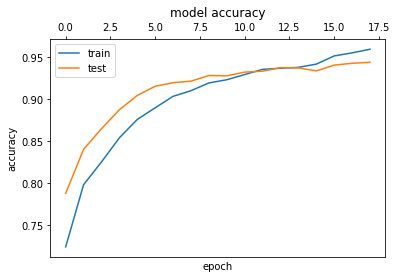

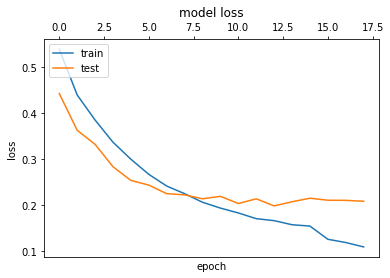

              precision    recall  f1-score   support

           0     0.7446    0.8371    0.7881       491
           1     0.7814    0.6698    0.7213       427

    accuracy                         0.7593       918
   macro avg     0.7630    0.7534    0.7547       918
weighted avg     0.7617    0.7593    0.7570       918



<Figure size 432x288 with 0 Axes>

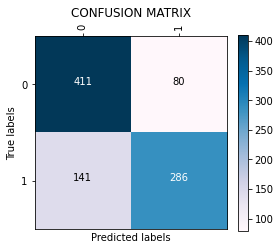

In [63]:
epochs         = 21
num_sentims    = 21
learning_rates = [ 1e-3, ]
batch_sizes    = [ 8, ]
dropouts1      = [ 0.6, ]
dropouts2      = [ 0.6, ]
units_list     = [ 150, ]
optimizers     = [ Adam, ]        # Adam, RMSprop, Nadam, Adadelta, Adagrad, Adamax, Ftrl
emb            = switch_dict[ switch ]

all_combinations = list(itertools.product(*[learning_rates, batch_sizes, dropouts1, dropouts2, units_list, optimizers]))

time_stamp1 = time.strftime("%Y%m%dT%H%M") 
file_name   = f'logs/log_{time_stamp1}.txt'
wdir        = 'ckps/current/'

with open( file_name, 'w', encoding='utf-8' ) as f:
    experiment_name = 'NO UPSAMPLING, N0 SENTIMENT, 1 BiLSTM\n'
    f.write( experiment_name )
    for learning_rate, batch_size, dropout1, dropout2, units, optimizer in all_combinations:
        
        time_stamp = time.strftime("%Y%m%dT%H%M") 
        optimizer_name = optimizer.__module__.split('.')[-1].capitalize()
        params = f'\nEmbeddings={emb}, LR={learning_rate}, batch_size={batch_size}, dropout={dropout1}&{dropout2}, units={units}, optimizer={optimizer_name}'
        print( params )
        print( 'Timestamp:', time_stamp)
        f.write( params + '\nTimestamp: ' + time_stamp + '\n' )

        inputs_1         = Input(shape=(maxlen,))
        inputs_2         = Input(shape=(maxlen,))
        embed_sentiment  = Embedding( num_sentims+1, EMBED_SIZE, )(inputs_2)
        embed_spacy      = Embedding( vocab_size, EMBED_SIZE, weights=[embedding_matrix], trainable=False )(inputs_1)   
        concat           = Concatenate(axis=1)([                                                                          
                                                 embed_spacy,
                                                 embed_sentiment,            
                                                 #embed_glove,
                                                 #embed_w2vec,                                                 
                                             ])
        x               = Bidirectional(LSTM( units, dropout=dropout1, return_sequences=True ))(concat)
        x               = Bidirectional(LSTM( units//2, dropout=dropout2, return_sequences=False ))(x)
        dense_layer     = Dense(1, activation='sigmoid')(x)
        model           = Model(inputs=[inputs_1,inputs_2 ], outputs=dense_layer) 
        model.summary()


        model.compile( loss='binary_crossentropy',
                       #optimizer=optimizer( lr=learning_rate,
                       #                     rho=0.8,
                       #                     momentum=0.0,
                       #                     centered=False,),
                       optimizer=optimizer( lr=learning_rate, ),
                       metrics=['accuracy'] )

        early_stop = tf.keras.callbacks.EarlyStopping(
                                                       monitor='val_loss',
                                                       patience=5,
                                                       restore_best_weights=False,
                                                       verbose=2,
                                                     )
        
        reduce_lr  = tf.keras.callbacks.ReduceLROnPlateau( 
                                                           monitor="val_loss",                                                           
                                                           patience=2,
                                                           factor=0.2,
                                                           min_lr=5e-5,
                                                           verbose=2,
                                                         )
        
        filepath   = wdir + time_stamp + '-epoch{epoch:02d}-val_accu_{val_accuracy:.2f}-val_loss_{val_loss:.2f}.hdf5'
        checkpoint = tf.keras.callbacks.ModelCheckpoint( 
                                                            filepath,
                                                            verbose=0,
                                                          )
        
        history = model.fit( [X_train, X_train_sentim],
                             y_train,
                             batch_size=batch_size,
                             epochs=epochs,
                             verbose=2,
                             validation_split=0.2,
                             callbacks=[ early_stop, reduce_lr, checkpoint ]# 
                            )

        score = model.evaluate([X_test, X_test_sentim], y_test, verbose=1)
        test_results = f'Test Score: {score[0]}\nTest Accuracy: {score[1]}\n'
        print( test_results )
        f.write( test_results + '\n')

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])

        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train','test'], loc='upper left')
        plt.show()

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])

        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train','test'], loc='upper left')
        plt.show()

        # PREDICT ALL
        predictions = model.predict([X_test, X_test_sentim])
        predictions = np.round( predictions )
        clf_report = classification_report(y_test, predictions, digits=4)
        print( clf_report )
        f.write( clf_report + '\n')

        # PRINT THE CONFUSION MATRIX
        labels = list( range( len(np.unique(y_test))))
        cm = confusion_matrix(y_test, predictions)
        np.set_printoptions(precision=2)
        plt.figure()
        plot_confusion_matrix(cm, classes=labels)
        
        record_end = '='*70
        print( record_end )
        f.write( record_end + '\n')


7/7 [==============================] - 0s 22ms/step - loss: 1.2605 - accuracy: 0.7050
Test Score: 1.2604914903640747
Test Accuracy: 0.7049999833106995

              precision    recall  f1-score   support

           0     0.6815    0.8519    0.7572       108
           1     0.7538    0.5326    0.6242        92

    accuracy                         0.7050       200
   macro avg     0.7177    0.6922    0.6907       200
weighted avg     0.7148    0.7050    0.6960       200



<Figure size 432x288 with 0 Axes>

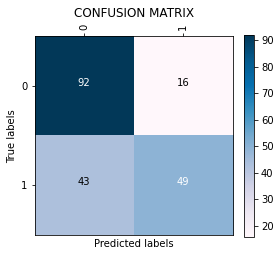

In [64]:
score = model.evaluate([X_testb, X_test_sentimb], y_testb, verbose=1)
test_results = f'Test Score: {score[0]}\nTest Accuracy: {score[1]}\n'
print( test_results )

predictions = model.predict([X_testb, X_test_sentimb])
predictions = np.round( predictions )
clf_report = classification_report(y_testb, predictions, digits=4)
print( clf_report )

# PRINT THE CONFUSION MATRIX
labels = list( range( len(np.unique(y_testb))))
cm = confusion_matrix(y_testb, predictions)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=labels)

In [ ]:
gc.collect()